# Nurvv K-Means

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
import time

%matplotlib inline

## NURVV DATASET
Extract IMU (accelerometer + gyroscope) from 2 distinct runs

In [8]:
data_folder = '2019-07-23_CricketPitch_Grant' # _Josh

In [9]:
df_acc = pd.read_csv(data_folder + '/imu_acc.csv') 
df_gyro = pd.read_csv(data_folder + '/imu_gyro.csv') 
df_gyro['Gyro-X'] = df_gyro['Gyro-X'].multiply(0.017453)
df_gyro['Gyro-Y'] = df_gyro['Gyro-Y'].multiply(0.017453)
df_gyro['Gyro-Z'] = df_gyro['Gyro-Z'].multiply(0.017453)
df_acc['Accel-X'] = df_acc['Accel-X'].multiply(9.80665)
df_acc['Accel-Y'] = df_acc['Accel-Y'].multiply(9.80665)
df_acc['Accel-Z'] = df_acc['Accel-Z'].multiply(9.80665)

In [10]:
data_imu = [(df_acc['TimeStamp'].values - df_acc['TimeStamp'].values[0])/1_000,
            df_acc['Accel-X'].values, 
            df_acc['Accel-Y'].values, 
            df_acc['Accel-Z'].values, 
            df_gyro['Gyro-X'].values, 
            df_gyro['Gyro-Y'].values, 
            df_gyro['Gyro-Z'].values]

df_imu = pd.DataFrame(data_imu)
df_imu = df_imu.T
df_imu.columns = ['Timestamp', 'Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']
df_imu = df_imu.set_index('Timestamp')

# If we want data normalized
# Since for us the big oscillations are important as they indicate IC, we choose to not normalized data
#although this is usually required to not give more weights to certain features than others
#df_imu=(df_imu-df_imu.min())/(df_imu.max()-df_imu.min())

In [16]:
df_imu.index[0]

2234381487.0

In [26]:
initial_timestamp = 2_434_481_487
final_timestamp = 2_436_981_487
df_short_imu = df_imu[initial_timestamp:final_timestamp]
df_short_imu.head()

,Accel-X,Accel-Y,Accel-Z,Gyro-X,Gyro-Y,Gyro-Z
TimeStamp,,,,,,
2.434482e+09,34.083855,-2.020709,4.137180,-1.004612,-0.432068,3.333097
2.434483e+09,32.982520,-1.963242,3.801989,-0.919475,-0.297978,3.396950
2.434484e+09,31.967384,-1.838747,3.648760,-0.847109,-0.208585,3.467187
2.434485e+09,30.971391,-1.465251,3.552998,-0.789642,-0.168145,3.541682
2.434486e+09,29.889218,-0.881069,3.849875,-0.719404,-0.189429,3.626819


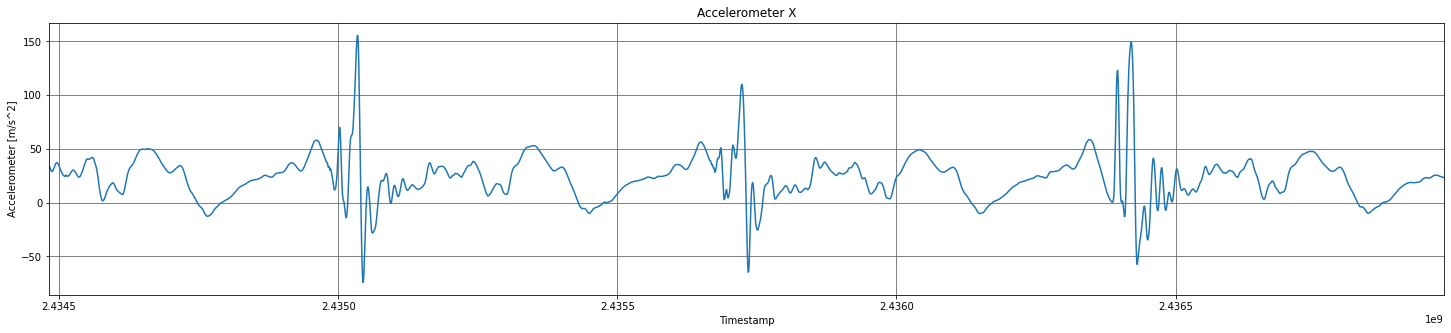

In [27]:
plt.figure(figsize=(25,5))

plt.title(f"Accelerometer X")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_short_imu.index, df_short_imu['Accel-X'])
plt.xlim(df_short_imu.index[0], df_short_imu.index[-1])
plt.show()

# Apply PCA

<Figure size 1800x720 with 0 Axes>

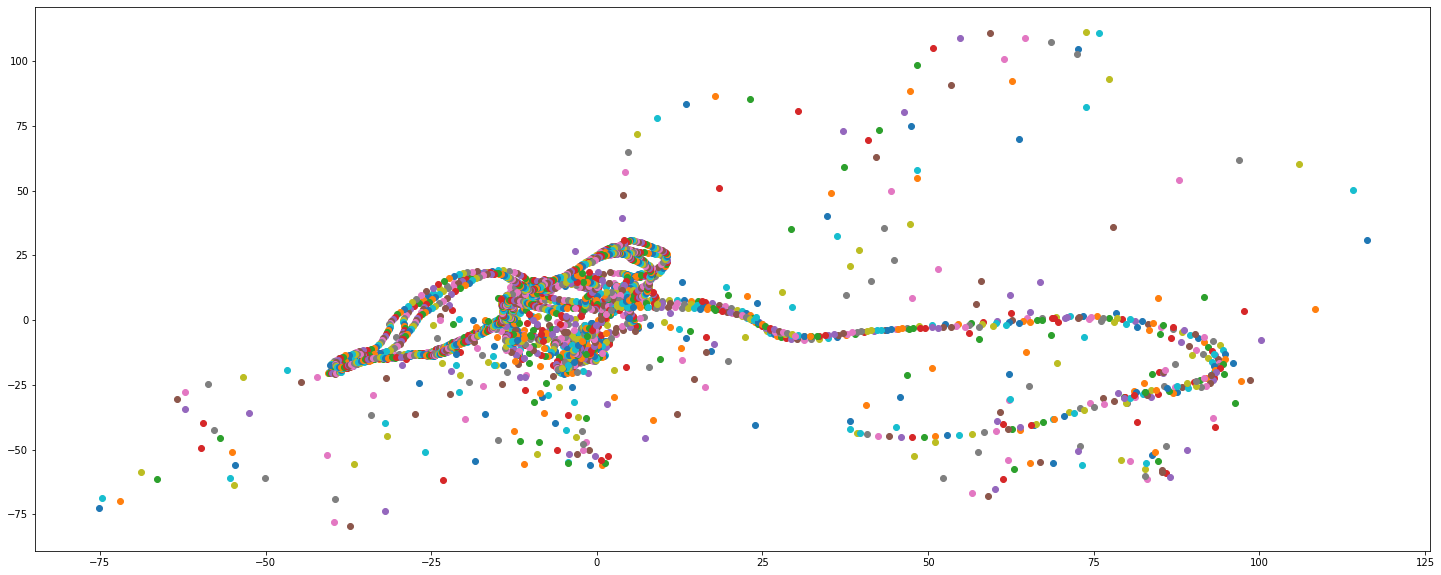

In [28]:
# PCA (2 dimensions)
plt.figure(figsize=(25,10))
pca = PCA(n_components=2)
IMU = pca.fit(df_short_imu).transform(df_short_imu)
plt.figure(figsize=(25,10))
for i in range(len(IMU)):
    plt.scatter(IMU[i][0], IMU[i][1])


This allows to understand if there's a pattern on the data. 
Since when we plotted the PCA data above we lost the notion of time.

In [8]:
# Only for interpretation purpose
if 0:
    %matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plt.ion()

    fig.canvas.draw()

    x = list()
    y = list()
    for i in range(len(IMU)):
        x.append(IMU[i][0])
        y.append(IMU[i][1])
        ax.scatter(IMU[i][0], IMU[i][1])
        ax2.scatter(df_short_imu.index[i], df_short_imu['Accel-X'].values[i])
        fig.canvas.draw()
        
    %matplotlib inline

## Kmeans on 6D Data

In [29]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_imu)
pd.DataFrame.from_records(kmeans.cluster_centers_, 
                          columns=['Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z'])

,Accel-X,Accel-Y,Accel-Z,Gyro-X,Gyro-Y,Gyro-Z
0,48.146970,-64.678972,18.307942,0.867336,-0.484105,-0.942194
1,19.070502,2.575093,-1.347791,0.234267,-0.057575,0.134226


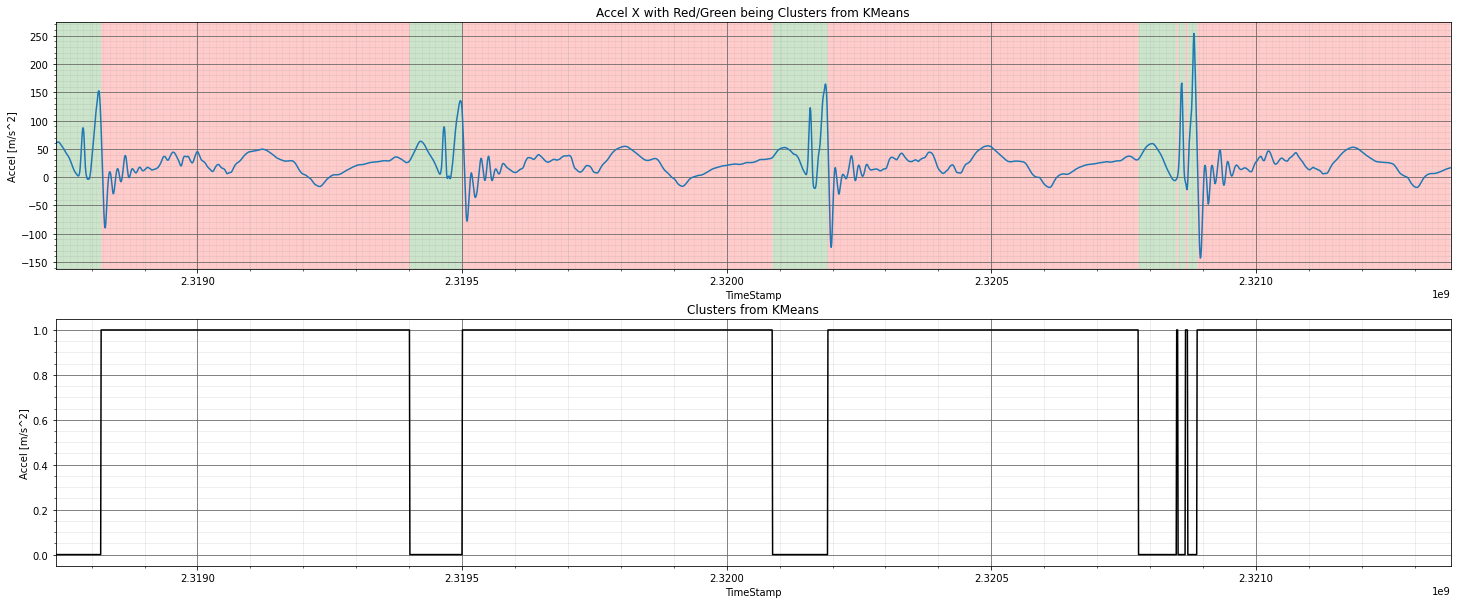

In [30]:
# Due to the amount of data we'll shorten the plotting to between these idx
idx_start = 96000
idx_end = 99000

plt.figure(figsize=(25,10))
plt.subplot(211)
plt.title(f"Accel X with Red/Green being Clusters from KMeans")
plt.ylabel('Accel [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(df_imu.index[idx_start:idx_end], df_imu['Accel-X'].values[idx_start:idx_end])
colors = ['green', 'red', 'tab:orange', 'tab:blue']
for idx,lbl in enumerate(kmeans.labels_[idx_start+1:idx_end]):
    plt.gca().axvspan(df_imu.index[idx_start+idx+1], df_imu.index[idx_start+idx], alpha=0.05, color=colors[lbl])
plt.xlim([df_imu.index[idx_start], df_imu.index[idx_end]])
        
#plt.plot(df_imu.index[idx_start:idx_end], 300*test[idx_start:idx_end], lw=2)
plt.subplot(212)
plt.title(f"Clusters from KMeans")
plt.ylabel('Accel [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(df_imu.index[idx_start:idx_end], kmeans.labels_[idx_start:idx_end], c='k')
plt.xlim([df_imu.index[idx_start], df_imu.index[idx_end]])

plt.show()

In [37]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_imu)
pd.DataFrame.from_records(kmeans.cluster_centers_, 
                          columns=['Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z'])

,Accel-X,Accel-Y,Accel-Z,Gyro-X,Gyro-Y,Gyro-Z
0,48.146970,-64.678972,18.307942,0.867336,-0.484105,-0.942194
1,19.070502,2.575093,-1.347791,0.234267,-0.057575,0.134226


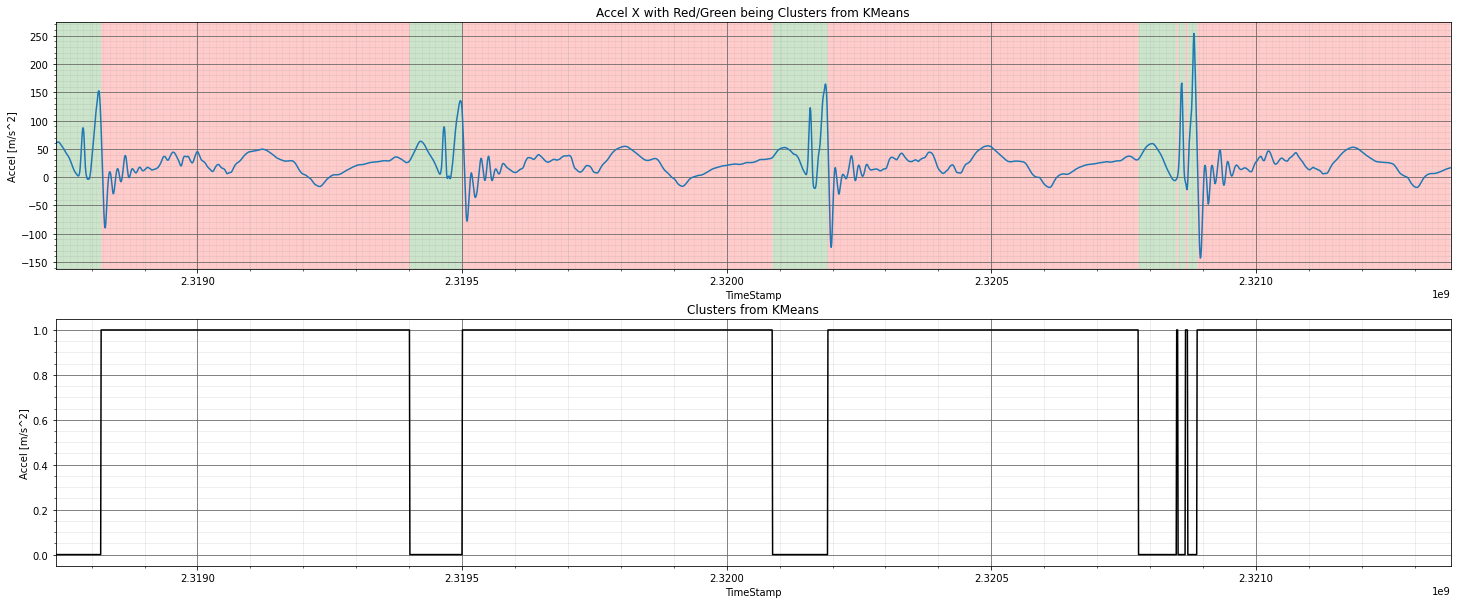

In [38]:
# Due to the amount of data we'll shorten the plotting to between these idx
idx_start = 96000
idx_end = 99000

plt.figure(figsize=(25,10))
plt.subplot(211)
plt.title(f"Accel X with Red/Green being Clusters from KMeans")
plt.ylabel('Accel [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(df_imu.index[idx_start:idx_end], df_imu['Accel-X'].values[idx_start:idx_end])
colors = ['green', 'red', 'tab:orange', 'tab:blue']
for idx,lbl in enumerate(kmeans.labels_[idx_start+1:idx_end]):
    plt.gca().axvspan(df_imu.index[idx_start+idx+1], df_imu.index[idx_start+idx], alpha=0.05, color=colors[lbl])
plt.xlim([df_imu.index[idx_start], df_imu.index[idx_end]])

plt.subplot(212)
plt.title(f"Clusters from KMeans")
plt.ylabel('Accel [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.plot(df_imu.index[idx_start:idx_end], kmeans.labels_[idx_start:idx_end], c='k')
plt.xlim([df_imu.index[idx_start], df_imu.index[idx_end]])

plt.show()

# Extract Features
Instead of using the raw data we could potentially extract important features, see "Accurate Estimation of Running
Temporal Parameters Using Foot-Worn Inertial Sensors". As an example, let us depic the acceleration and gyroscope magnitudes.

In [31]:
data_imu_features = [df_acc['TimeStamp'].values[1:],
                     np.sqrt(df_acc['Accel-X']**2+df_acc['Accel-Y']**2+df_acc['Accel-Z']**2)[1:], 
                     np.sqrt(df_gyro['Gyro-X']**2+df_gyro['Gyro-Y']**2+df_gyro['Gyro-Z']**2)[1:], 
                     np.diff(np.sqrt(df_acc['Accel-X']**2+df_acc['Accel-Y']**2+df_acc['Accel-Z']**2)),
                     np.diff(np.sqrt(df_gyro['Gyro-X']**2+df_gyro['Gyro-Y']**2+df_gyro['Gyro-Z']**2))]

df_imu_features = pd.DataFrame(data_imu_features)
df_imu_features = df_imu_features.T
df_imu_features.columns = ['TimeStamp', 'Accel-Mag', 'Gyro-Mag', 'Accel-Jerk', 'Gyro-Jerk']
df_imu_features=df_imu_features.set_index('TimeStamp')

In [32]:
df_imu_features.head()

,Accel-Mag,Gyro-Mag,Accel-Jerk,Gyro-Jerk
TimeStamp,,,,
2.234382e+09,9.806544,0.121095,0.094814,-0.000093
2.234383e+09,9.872289,0.124580,0.065746,0.003485
2.234384e+09,9.845509,0.121692,-0.026780,-0.002888
2.234385e+09,9.795413,0.120646,-0.050096,-0.001047
2.234386e+09,9.778338,0.118677,-0.017075,-0.001969


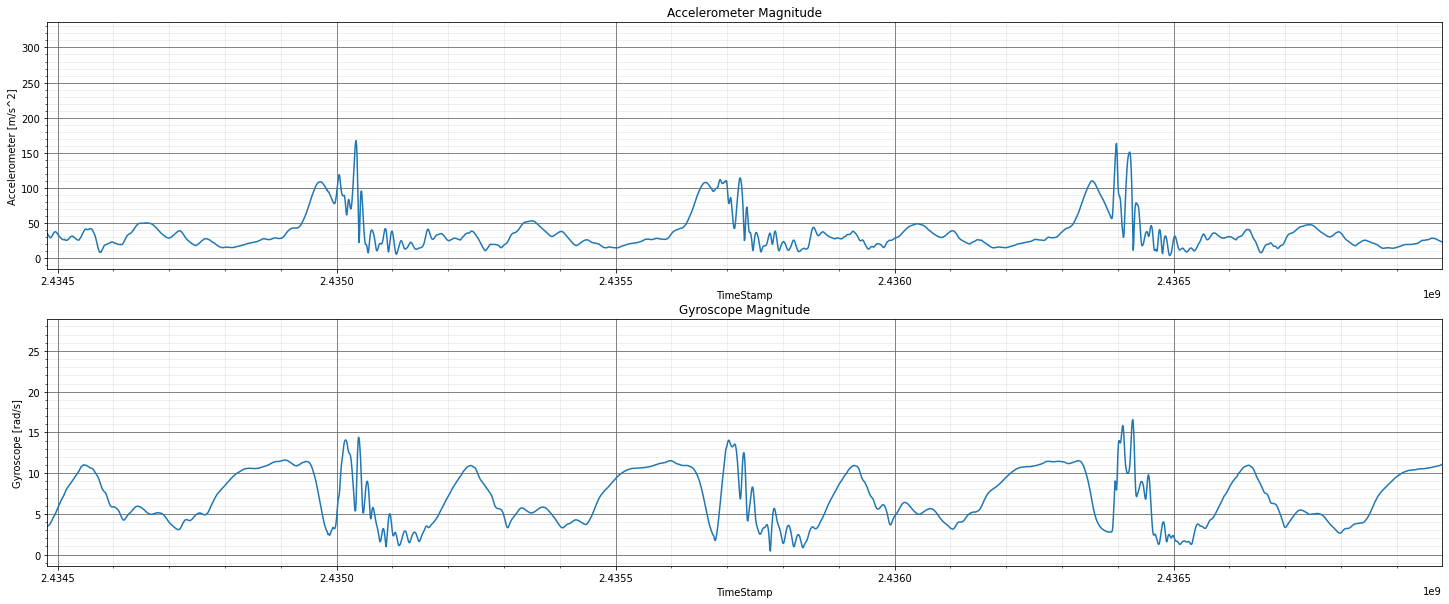

In [33]:
plt.figure(figsize=(25,10))

plt.subplot(211)
plt.title(f"Accelerometer Magnitude")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.xlim(initial_timestamp, final_timestamp)
plt.plot(df_imu_features.index, df_imu_features['Accel-Mag'])

plt.subplot(212)
plt.title(f"Gyroscope Magnitude")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.xlim(initial_timestamp, final_timestamp)
plt.plot(df_imu_features.index, df_imu_features['Gyro-Mag'])

plt.show()

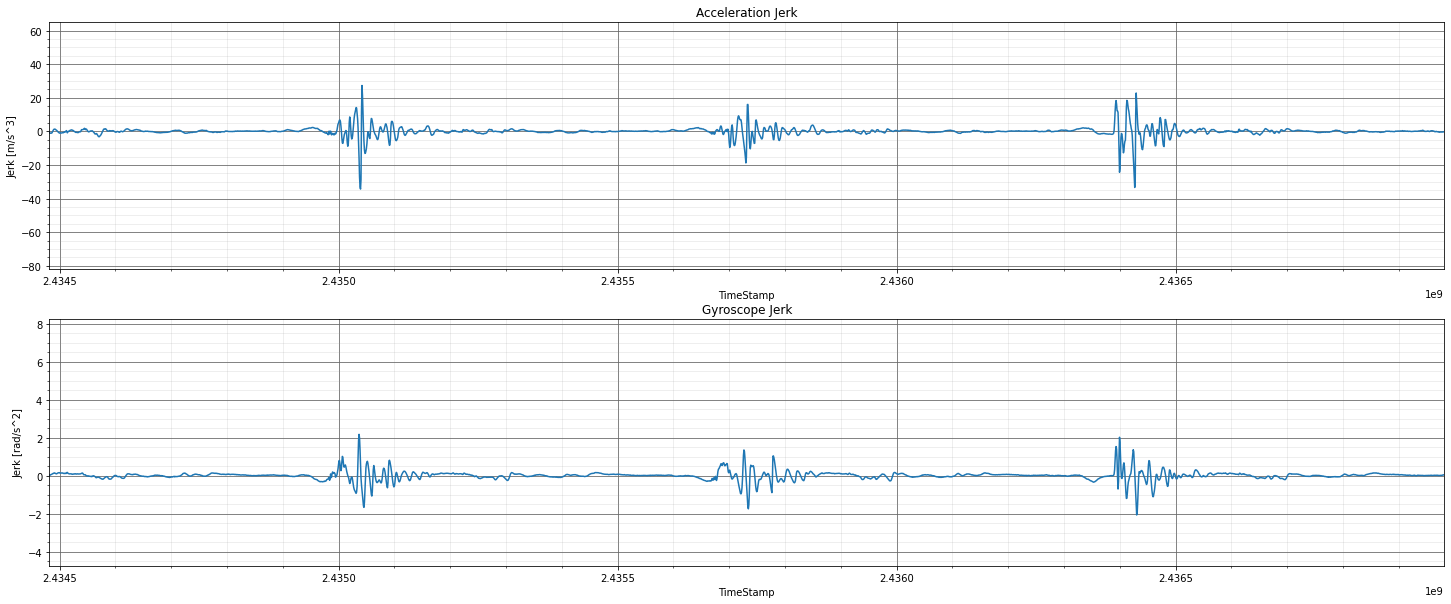

In [34]:
plt.figure(figsize=(25,10))

plt.subplot(211)
plt.title(f"Acceleration Jerk")
plt.ylabel('Jerk [m/s^3]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.xlim(initial_timestamp, final_timestamp)
plt.plot(df_imu_features.index, df_imu_features['Accel-Jerk'])

plt.subplot(212)
plt.title(f"Gyroscope Jerk")
plt.ylabel('Jerk [rad/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('TimeStamp')
plt.xlim(initial_timestamp, final_timestamp)
plt.plot(df_imu_features.index, df_imu_features['Gyro-Jerk'])

plt.show()

# Apply PCA

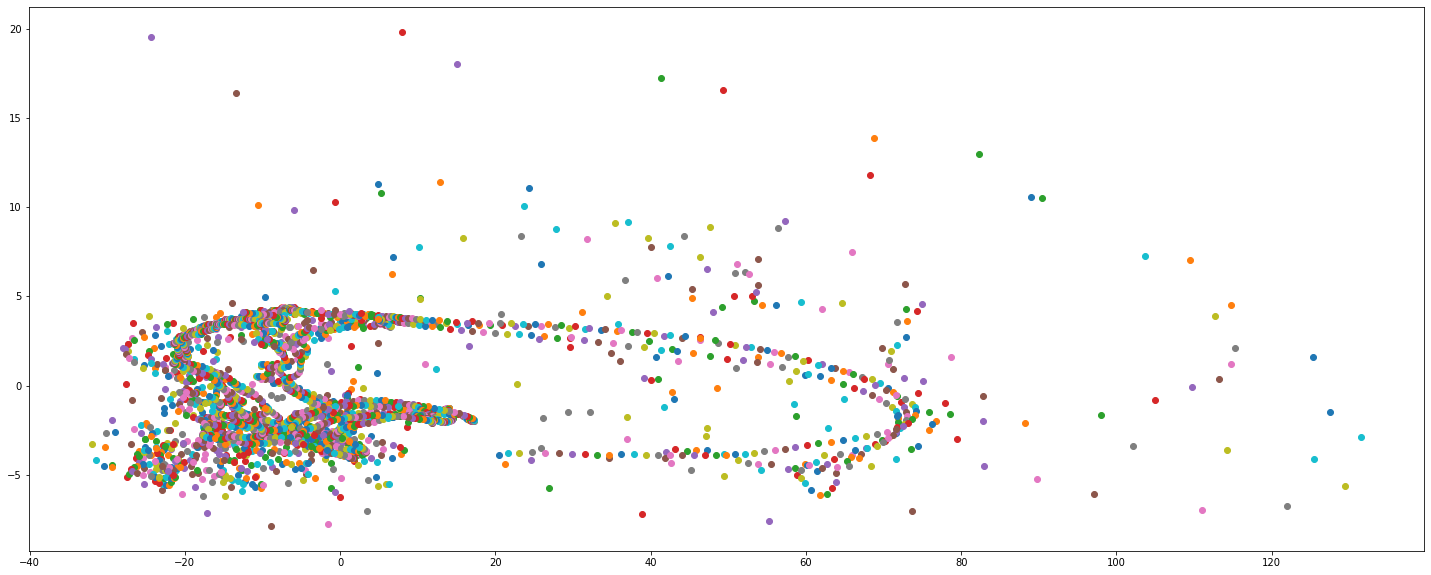

In [35]:
df_short_imu_features = df_imu_features[initial_timestamp:final_timestamp]
df_short_imu_features.head()

# PCA (2 dimensions)
pca = PCA(n_components=2)
IMU = pca.fit(df_short_imu_features).transform(df_short_imu_features)
plt.figure(figsize=(25,10))
for i in range(len(IMU)):
    plt.scatter(IMU[i][0], IMU[i][1])

In [36]:
# Only for interpretation purpose
if 0:
    %matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plt.ion()

    fig.canvas.draw()

    x = list()
    y = list()
    for i in range(len(IMU)):
        x.append(IMU[i][0])
        y.append(IMU[i][1])
        ax.scatter(IMU[i][0], IMU[i][1])
        ax2.scatter(df_short_imu.index[i], df_short_imu['Accel-X'].values[i])
        fig.canvas.draw()
        
    %matplotlib inline

# Kmeans on 4D Features Data

In [17]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_imu_features)
pd.DataFrame.from_records(kmeans.cluster_centers_, 
                          columns=['Accel-Mag', 'Gyro-Mag', 'Accel-Jerk', 'Gyro-Jerk'])

,Accel-Mag,Gyro-Mag,Accel-Jerk,Gyro-Jerk
0,21.753582,4.601372,-0.111478,0.003071
1,99.225974,8.159495,1.144701,-0.031532
